**Demo Architecture**:

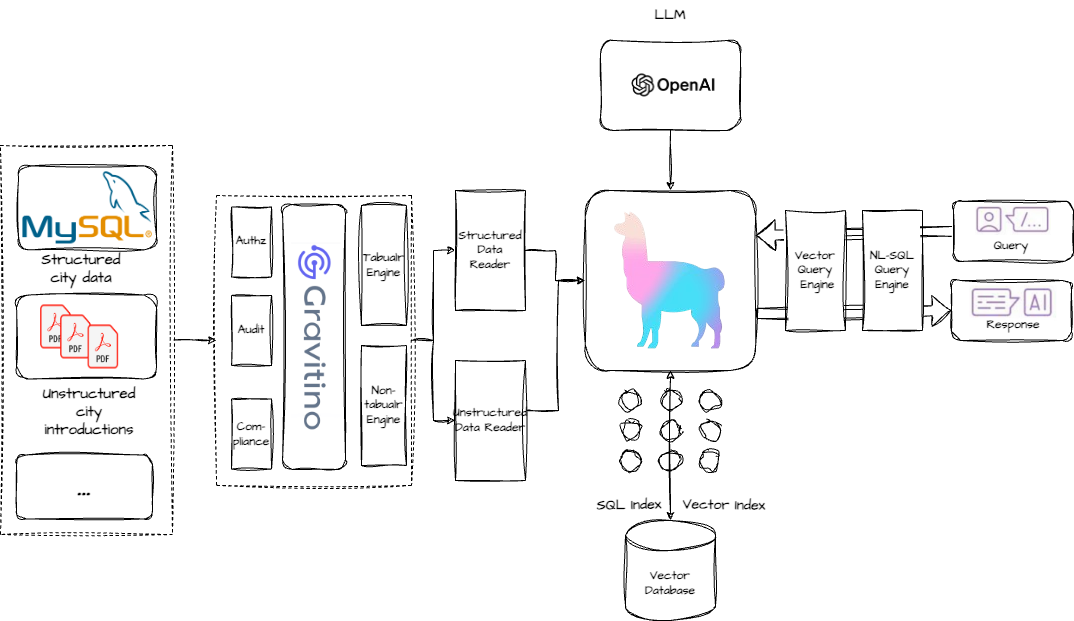


<a href="https://colab.research.google.com/github/jerryjliu/llama_index/blob/main/docs/docs/examples/query_engine/SQLJoinQueryEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Install the necessary packages and create some necessary methods.

In [ ]:
%pip install llama-index-readers-wikipedia
%pip install llama-index-llms-openai
%pip install llama-index
%pip install apache-gravitino==0.6.1
%pip install sqlalchemy-trino

In [ ]:
# Configure the OpenAI API key

import os

os.environ["OPENAI_API_KEY"] = ""
os.environ["OPENAI_API_BASE"] = ""

In [ ]:
# Define metadata in Gravitino
from gravitino import NameIdentifier, GravitinoClient, Catalog, Fileset, GravitinoAdminClient

gravitino_url = "http://gravitino:8090"
metalake_name = "metalake_demo"

catalog_name = "catalog_fileset"

schema_name = "countries"

fileset_name = "cities"
fileset_ident = NameIdentifier.of(schema_name, fileset_name)

gravitino_admin_client = GravitinoAdminClient(uri=gravitino_url)
gravitino_client = GravitinoClient(uri=gravitino_url, metalake_name=metalake_name)

In [ ]:
# NOTE: This is ONLY necessary in jupyter notebook.
# Details: Jupyter runs an event-loop behind the scenes.
#          This results in nested event-loops when we start an event-loop to make async queries.
#          This is normally not allowed, we use nest_asyncio to allow it for convenience.
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.WARN)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))
logging.getLogger().setLevel(level=logging.WARN)


In [ ]:
# Create catalog
demo_catalog = None
try:
    demo_catalog = gravitino_client.load_catalog(name=catalog_name)
except Exception as e:
    demo_catalog = gravitino_client.create_catalog(name=catalog_name,
                                               catalog_type=Catalog.Type.FILESET,
                                               comment="demo",
                                               provider="hadoop",
                                               properties={})

print(demo_catalog)

# Create schema and fileset
schema_countries = None
try:
    schema_countries = demo_catalog.as_schemas().load_schema(schema_name=schema_name)
except Exception as e:
    schema_countries = demo_catalog.as_schemas().create_schema(schema_name=schema_name,
                                                           comment="countries",
                                                           properties={})
print(schema_countries)

fileset_cities = None
try:
    fileset_cities = demo_catalog.as_fileset_catalog().load_fileset(ident=fileset_ident)
except Exception as e:
    fileset_cities = demo_catalog.as_fileset_catalog().create_fileset(ident=fileset_ident,
                                                                      fileset_type=Fileset.Type.EXTERNAL,
                                                                      comment="cities",
                                                                      storage_location="/tmp/gravitino/data/pdfs",
                                                                      properties={})
print(fileset_cities)

Load the fileset from Gravitino

In [ ]:
# load fileset catalog and fileset

loaded_catalog_demo = gravitino_client.load_catalog(name=catalog_name)
print(loaded_catalog_demo)

loaded_schema_countries = loaded_catalog_demo.as_schemas().load_schema(schema_name=schema_name)
print(loaded_schema_countries)

loaded_fileset_cities = loaded_catalog_demo.as_fileset_catalog().load_fileset(ident=fileset_ident)
print(loaded_fileset_cities)

### Create Database Schema + Test Data

Here we use Trino with our Gravitino connector to query the data from table.

In [ ]:
from sqlalchemy import create_engine
from trino.sqlalchemy import URL
from sqlalchemy.sql.expression import select, text

trino_engine = create_engine('trino://admin@trino:8080/catalog_mysql/demo_llamaindex')

connection = trino_engine.connect();

with trino_engine.connect() as connection:
    cursor = connection.exec_driver_sql("SELECT * FROM catalog_mysql.demo_llamaindex.city_stats")
    print(cursor.fetchall())

### Load Data

We first show how to convert a Document into a set of Nodes, and insert into a DocumentStore.

In [ ]:
from llama_index.core import SimpleDirectoryReader
from gravitino import gvfs


fs = gvfs.GravitinoVirtualFileSystem(
    server_uri=gravitino_url,
    metalake_name=metalake_name
    )

fileset_virtual_location = "fileset/catalog_fileset/countries/cities"

reader = SimpleDirectoryReader(
    input_dir=fileset_virtual_location,
    fs=fs,
    recursive=True)
wiki_docs = reader.load_data()
print(wiki_docs)

### Build SQL Index

In [ ]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(trino_engine, include_tables=["city_stats"])

### Build Vector Index

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI


# Insert documents into vector index
# Each document has metadata of the city attached

vector_indices = {}
vector_query_engines = {}
cities = ["Toronto", "Berlin", "Tokyo"]

for city, wiki_doc in zip(cities, wiki_docs):
    vector_index = VectorStoreIndex.from_documents([wiki_doc])

    query_engine = vector_index.as_query_engine(
        similarity_top_k=2, llm=OpenAI(model="gpt-3.5-turbo")
    )

    vector_indices[city] = vector_index
    vector_query_engines[city] = query_engine

### Define Query Engines, Set as Tools

In [ ]:
from llama_index.core.query_engine import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["city_stats"],
)

In [ ]:
from llama_index.core.tools import QueryEngineTool
from llama_index.core.tools import ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

query_engine_tools = []
for city in cities:
    query_engine = vector_query_engines[city]

    query_engine_tool = QueryEngineTool(
        query_engine=query_engine,
        metadata=ToolMetadata(
            name=city, description=f"Provides information about {city}"
        ),
    )
    query_engine_tools.append(query_engine_tool)

s_engine = SubQuestionQueryEngine.from_defaults(
    query_engine_tools=query_engine_tools, llm=OpenAI(model="gpt-3.5-turbo")
)


In [ ]:
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    description=(
        "Useful for translating a natural language query into a SQL query over"
        " a table containing: city_stats, containing the population/country of"
        " each city"
    ),
)
s_engine_tool = QueryEngineTool.from_defaults(
    query_engine=s_engine,
    description=(
        f"Useful for answering semantic questions about different cities"
    ),
)

### Define SQLJoinQueryEngine

In [ ]:
from llama_index.core.query_engine import SQLJoinQueryEngine

query_engine = SQLJoinQueryEngine(
    sql_tool, s_engine_tool, llm=OpenAI(model="gpt-4")
)

In [ ]:
response = query_engine.query(
    "Tell me about the arts and culture of the city with the highest"
    " population"
)

In [ ]:
print(str(response))

In [ ]:
response = query_engine.query(
    "Compare and contrast the demographics of Berlin and Toronto"
)

In [ ]:
print(str(response))

In [ ]:
response = query_engine.query(
    "Show me the general history of the cities for countries of Japan and Germany"
)

print(response)